In [808]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS, GMM
from scipy import stats
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

In [809]:
# CHANGE SOURCE FOR REAL HACKATHON

df = pd.read_csv('https://raw.githubusercontent.com/yihuanxu/mban5110/refs/heads/main/data_set_hackathon.csv')
df

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001
...,...,...,...,...,...,...,...,...,...,...,...
2415,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003
2416,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003
2417,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003
2418,13.07.2011,15.02.2012,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819210,107.10,EUR,10,FI0003


Hackathon Questions to Answer:

1. How many distinct orders are received in each month?
2. Which items are demanded (i.e., classification-choice model)?
3. What is the quantity demanded for each item in these orders?
4. What is the demand lead time of these orders (i.e., time elapsed from the instant when
an order is received until its delivery)?

Prof Notes:

You may notice that dataset is transactional. First, you must group the transactions to have monthly information—that is, how many distinct orders are received each month (i.e., counting unique order codes grouped by the month of the order date)? Then, you can develop a predictive model (e.g., time series) to forecast the number of distinct orders.   
 
Second, you must develop a classification model (choice model) for the customers’ selection of the products. Here, please be careful. Given the seasonality in the apparel industry, the season must be added as an explanatory variable to the choice model. Season is a categorical variable, so you must use get-dummies or an appropriate encoding scheme.
 
The third uncertainty is quantity demanded. You may use empirical data to characterize this uncertainty. For example, empirical quantile for each product can be used like statistical distribution of quantity demanded for them ( https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html).
 
You can follow a similar approach to analyze the demand lead time. Empirical quantile information can also be useful for the demand lead time.
 
After you characterize each uncertainty by predictive models, classification methods, or empirically, you can apply Monte Carlo simulation to consolidate them into total demand. After simulation, you must analyze simulated data and distinguish advance demand from urgent demand. At this stage, you can compare the simulated advance demand with the actual advance demand in the test set. This comparison helps you calibrate the data and improve the forecast accuracy.  

In [810]:
df.describe()

,Customer Order Code,value
count,2.420000e+03,2420.000000
mean,3.200672e+09,1162.976624
std,1.004408e+05,2560.595118
min,3.200435e+09,-0.030000
25%,3.200614e+09,33.030000
50%,3.200711e+09,70.490000
75%,3.200729e+09,1363.200000
max,3.201062e+09,38937.500000


In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [812]:
# Convert date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Verify the conversion
print(df[['order_date', 'requested_delivery_date']].dtypes)

order_date                 datetime64[ns]
requested_delivery_date    datetime64[ns]
dtype: object


In [813]:
# convert items to numeric
df['items'] = pd.to_numeric(df['items'], errors='coerce')

In [814]:
df.isnull().sum()

order_date                   0
requested_delivery_date      0
Customer Country Code        0
Product Code                 0
Description                  0
order_type                   0
Customer Order Code          0
value                        0
Curr                         0
items                      346
Route                        0
dtype: int64

# EDA

In [815]:
# Count distinct customer order codes
distinct_customer_order_codes = df['Customer Order Code'].nunique()

print(f"Distinct Customer Order Codes: {distinct_customer_order_codes}")

Distinct Customer Order Codes: 989


In [816]:
# Group by 'Customer Order Code' and check the number of unique currencies
curr_check = df.groupby('Customer Order Code')['Curr'].nunique()

# Add a column to flag if the currency is inconsistent (more than 1 unique currency)
curr_check_df = curr_check.reset_index()
curr_check_df.rename(columns={'Curr': 'Unique Currencies'}, inplace=True)
curr_check_df['Is_Inconsistent'] = curr_check_df['Unique Currencies'] > 1

# Display the results
print(curr_check_df)

     Customer Order Code  Unique Currencies  Is_Inconsistent
0             3200435283                  1            False
1             3200435289                  1            False
2             3200435553                  1            False
3             3200435605                  1            False
4             3200435675                  1            False
..                   ...                ...              ...
984           3200819206                  1            False
985           3200819210                  1            False
986           3200828659                  1            False
987           3200900327                  1            False
988           3201061588                  1            False

[989 rows x 3 columns]


In [817]:
# checking if any order codes have different currencies from each other - none do!
inconsistent_orders = curr_check_df[curr_check_df['Is_Inconsistent']]
print(inconsistent_orders)

Empty DataFrame
Columns: [Customer Order Code, Unique Currencies, Is_Inconsistent]
Index: []


### Calculating Demand Lead Time

In [818]:
# First have to calculate the demand lead time

# Demand Lead Time = Requested Delivery Date - Order Date
# Gonna need EDA and feature engineering to create summary statistics (nedian + mean) for demand lead times by region, product, or customer
# Can also segment lead times into categories (e.g. short, medium, long)

df['Demand_lead_time'] = df['requested_delivery_date'] - df['order_date']
df

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Demand_lead_time
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6.0,RU0001,199 days
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23.0,RU0001,252 days
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7.0,RU0001,203 days
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9.0,RU0001,202 days
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5.0,RU0001,195 days
...,...,...,...,...,...,...,...,...,...,...,...,...
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12.0,FI0003,217 days
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12.0,FI0003,217 days
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12.0,FI0003,217 days
2418,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819210,107.10,EUR,10.0,FI0003,217 days


In [819]:
# just keeping this here so we can look at individual customer codes to see if anything is weird
filtered_df = df[df['Customer Order Code'] == 3201061588]
filtered_df

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Demand_lead_time
477,2012-11-19,2012-11-16,FR,L12134400,Parka Outdoor Lifestyle STD,VO,3201061588,120.0,EUR,8.0,FR0001,-3 days
523,2012-11-19,2012-11-16,FR,L12134500,Parka Outdoor Lifestyle STD,VO,3201061588,525.0,EUR,35.0,FR0001,-3 days
583,2012-11-19,2012-11-16,FR,L12134600,Parka Outdoor Lifestyle STD,VO,3201061588,15.0,EUR,1.0,FR0001,-3 days
742,2012-11-19,2012-11-16,FR,L12135800,Parka Outdoor Lifestyle STD,VO,3201061588,495.0,EUR,33.0,FR0001,-3 days


Im going to have to change the demand lead time... I think it has to be converted using quantile metrics

In [820]:
# Convert 'Demand_lead_time' to numeric in days
df['Demand_lead_time'] = pd.to_timedelta(df['Demand_lead_time'], errors='coerce').dt.days

# Replace negative or invalid lead times with 0
df['Demand_lead_time'] = df['Demand_lead_time'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)

### Creating a separate df that merges all of the same customer codes together

In [821]:
import pandas as pd

# Group by 'Customer Order Code' and aggregate the other columns
aggregated_df = df.groupby('Customer Order Code').agg({
    'order_date': 'min',  # Earliest order date
    'requested_delivery_date': 'max',  # Latest requested delivery date
    'Customer Country Code': 'first',  # Use the first occurrence
    'Product Code': ', '.join,  # Combine all product codes
    'Description': ', '.join,  # Combine all descriptions
    'order_type': 'first',  # Use the first occurrence
    'value': 'sum',  # Sum of order values
    'Curr': 'first',  # Use the first occurrence
    'items': 'sum',  # Total items
    'Route': 'first',  # Use the first occurrence
    'Demand_lead_time': 'mean'  # Average of cleaned lead times
}).reset_index()

# Display the result
aggregated_df

,Customer Order Code,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,value,Curr,items,Route,Demand_lead_time
0,3200435283,2009-07-08,2010-02-04,RU,L10705400,Parka Outdoor Lifestyle STD,VO,13148.00,RUB,32.0,RU0001,211.0
1,3200435289,2009-07-08,2010-01-28,RU,"L10705100, L10705200, L10705400, L10705600, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,12810.75,RUB,29.0,RU0001,204.0
2,3200435553,2009-07-13,2010-01-28,RU,"L10705000, L10705100, L10705400","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,15190.50,RUB,39.0,RU0001,199.0
3,3200435605,2009-07-14,2010-01-28,RU,L10705300,Parka Outdoor Lifestyle STD,VO,3847.50,RUB,9.0,RU0001,198.0
4,3200435675,2009-07-15,2010-02-01,RU,"L10705100, L10705300, L10705400, L10705600","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,13537.50,RUB,30.0,RU0001,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...
984,3200819206,2011-07-13,2012-03-01,HR,"L12916800, L12916900, L12917700, L12917900, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,813.96,EUR,76.0,FI0003,222.0
985,3200819210,2011-07-13,2012-03-01,HR,"L12916800, L12916900, L12917700, L12917900, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,599.76,EUR,56.0,FI0003,222.0
986,3200828659,2012-01-23,2013-04-15,RU,"L12918600, L12918700, L12918900, L12919000, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,17568.60,RUB,42.0,RU0001,156.0
987,3200900327,2012-04-13,2012-10-10,NL,L12136000,Parka Outdoor Lifestyle STD,VO,49.91,EUR,7.0,FR01NL,180.0


In [822]:
aggregated_df['Curr'].value_counts()

Curr
EUR    524
RUB    219
CHF    170
CZK     25
PLN     20
NOK     12
DKK     11
SEK      7
GBP      1
Name: count, dtype: int64

In [823]:
# Define exchange rates relative to EUR
exchange_rates_to_eur = {
    'EUR': 1,     # EUR is already the base currency
    'RUB': 0.012, # Example rate: 1 RUB = 0.012 EUR
    'CHF': 0.95,  # Example rate: 1 CHF = 0.95 EUR
    'CZK': 0.04,  # Example rate: 1 CZK = 0.04 EUR
    'PLN': 0.21,  # Example rate: 1 PLN = 0.21 EUR
    'NOK': 0.09,  # Example rate: 1 NOK = 0.09 EUR
    'DKK': 0.13,  # Example rate: 1 DKK = 0.13 EUR
    'SEK': 0.088, # Example rate: 1 SEK = 0.088 EUR
    'GBP': 1.17   # Example rate: 1 GBP = 1.17 EUR
}

# Add a new column with values converted to EUR
aggregated_df['value_in_eur'] = aggregated_df.apply(
    lambda row: row['value'] * exchange_rates_to_eur.get(row['Curr'], 1), axis=1
)

# Round the 'value_in_eur' column to two decimal places
aggregated_df['value_in_eur'] = aggregated_df['value_in_eur'].round(2)

# Display the updated DataFrame
aggregated_df

,Customer Order Code,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,value,Curr,items,Route,Demand_lead_time,value_in_eur
0,3200435283,2009-07-08,2010-02-04,RU,L10705400,Parka Outdoor Lifestyle STD,VO,13148.00,RUB,32.0,RU0001,211.0,157.78
1,3200435289,2009-07-08,2010-01-28,RU,"L10705100, L10705200, L10705400, L10705600, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,12810.75,RUB,29.0,RU0001,204.0,153.73
2,3200435553,2009-07-13,2010-01-28,RU,"L10705000, L10705100, L10705400","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,15190.50,RUB,39.0,RU0001,199.0,182.29
3,3200435605,2009-07-14,2010-01-28,RU,L10705300,Parka Outdoor Lifestyle STD,VO,3847.50,RUB,9.0,RU0001,198.0,46.17
4,3200435675,2009-07-15,2010-02-01,RU,"L10705100, L10705300, L10705400, L10705600","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,13537.50,RUB,30.0,RU0001,201.0,162.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,3200819206,2011-07-13,2012-03-01,HR,"L12916800, L12916900, L12917700, L12917900, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,813.96,EUR,76.0,FI0003,222.0,813.96
985,3200819210,2011-07-13,2012-03-01,HR,"L12916800, L12916900, L12917700, L12917900, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,599.76,EUR,56.0,FI0003,222.0,599.76
986,3200828659,2012-01-23,2013-04-15,RU,"L12918600, L12918700, L12918900, L12919000, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,17568.60,RUB,42.0,RU0001,156.0,210.82
987,3200900327,2012-04-13,2012-10-10,NL,L12136000,Parka Outdoor Lifestyle STD,VO,49.91,EUR,7.0,FR01NL,180.0,49.91


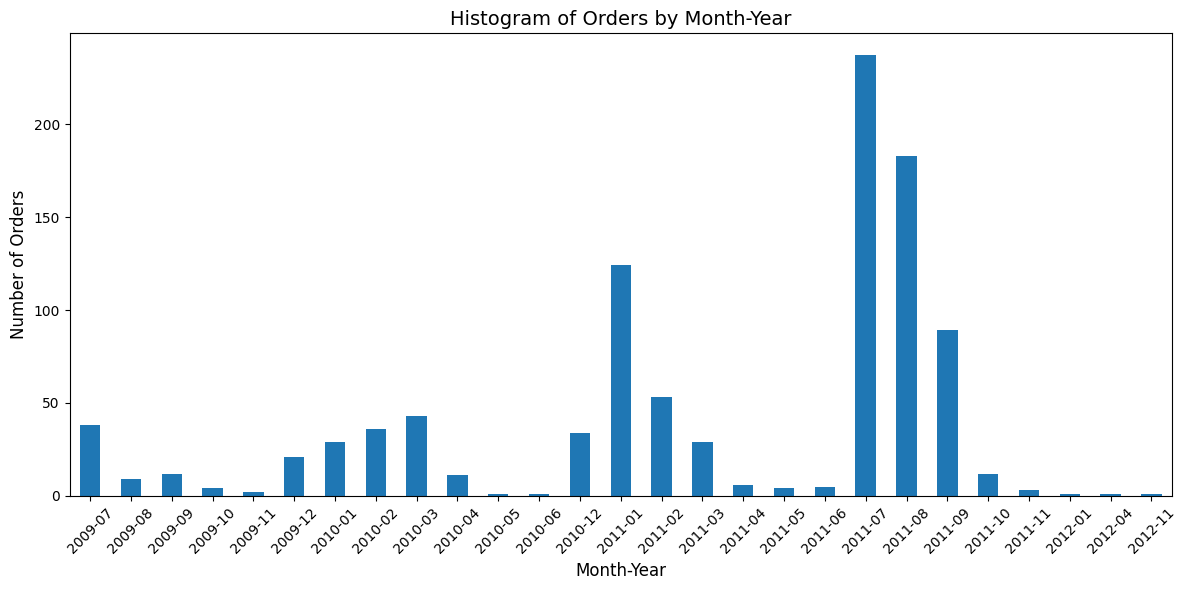

In [824]:
# Order histogram by month-year
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'order_date' is in datetime format
aggregated_df['order_date'] = pd.to_datetime(aggregated_df['order_date'], errors='coerce')

# Extract month-year from the 'order_date'
aggregated_df['month_year'] = aggregated_df['order_date'].dt.to_period('M')

# Count the number of orders for each month-year
orders_by_month_year = aggregated_df['month_year'].value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(12, 6))
orders_by_month_year.plot(kind='bar')
plt.title('Histogram of Orders by Month-Year', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

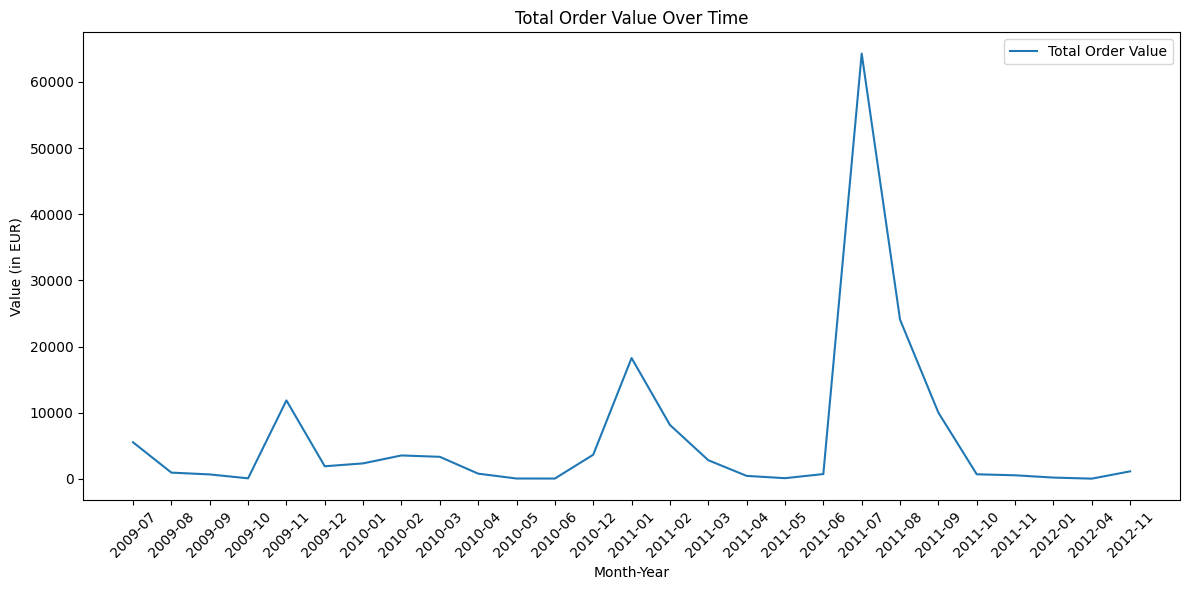

In [825]:
# line plot & rolling average

# Aggregate orders by month-year
time_series = aggregated_df.groupby('month_year')['value_in_eur'].sum()

# Plot total order value
plt.figure(figsize=(12, 6))
plt.plot(time_series.index.astype(str), time_series.values, label='Total Order Value')
plt.title('Total Order Value Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Value (in EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

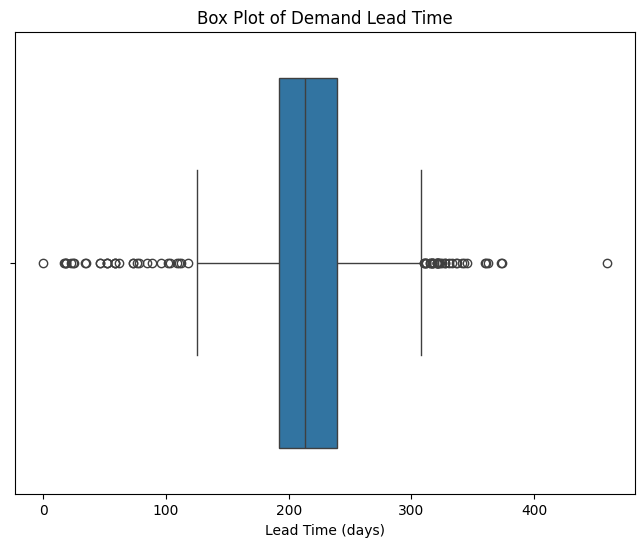

In [826]:
# Box Plot for demand lead time
plt.figure(figsize=(8, 6))
sns.boxplot(x=aggregated_df['Demand_lead_time'])
plt.title('Box Plot of Demand Lead Time')
plt.xlabel('Lead Time (days)')
plt.show()

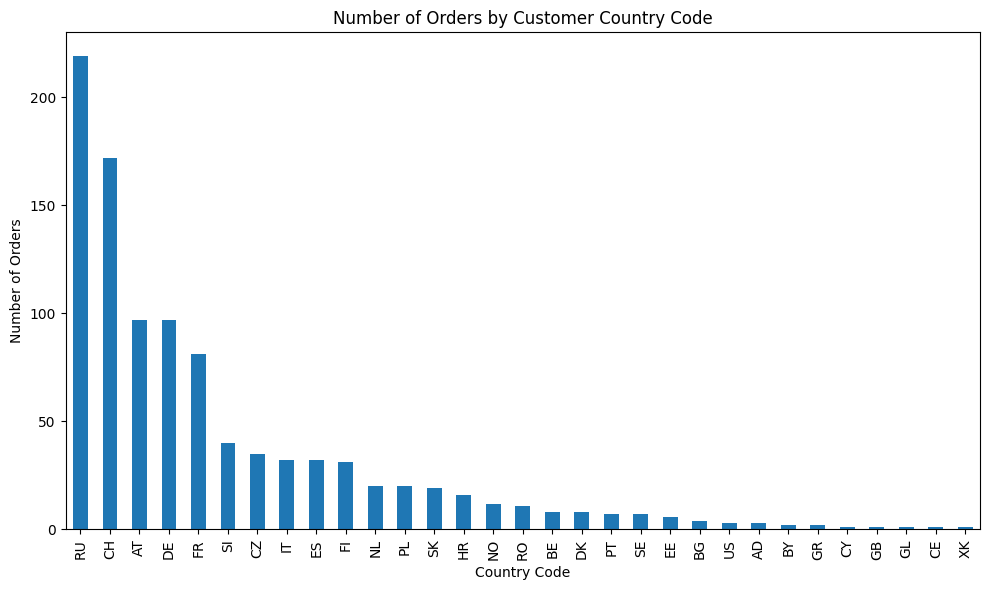

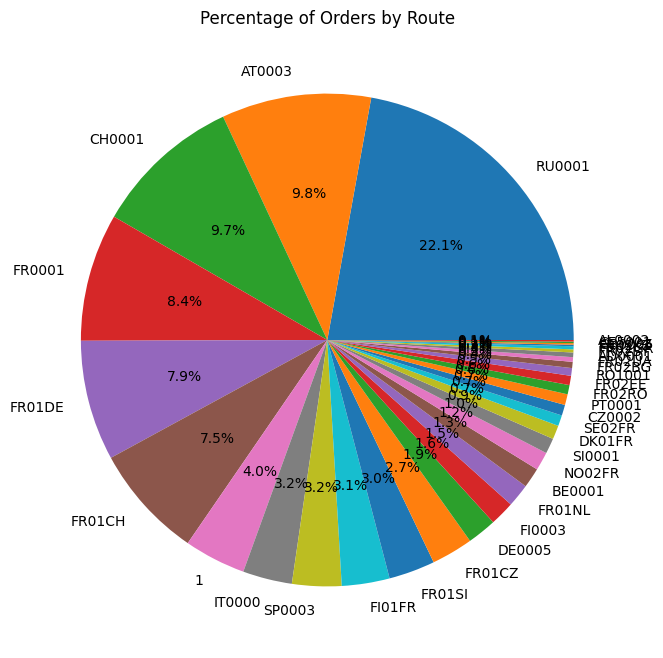

In [827]:
# Bar Plot for orders by Customer Country Code
plt.figure(figsize=(10, 6))
aggregated_df['Customer Country Code'].value_counts().plot(kind='bar')
plt.title('Number of Orders by Customer Country Code')
plt.xlabel('Country Code')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# Pie Chart for percentage of orders by Route
aggregated_df['Route'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8))
plt.title('Percentage of Orders by Route')
plt.ylabel('')
plt.show()

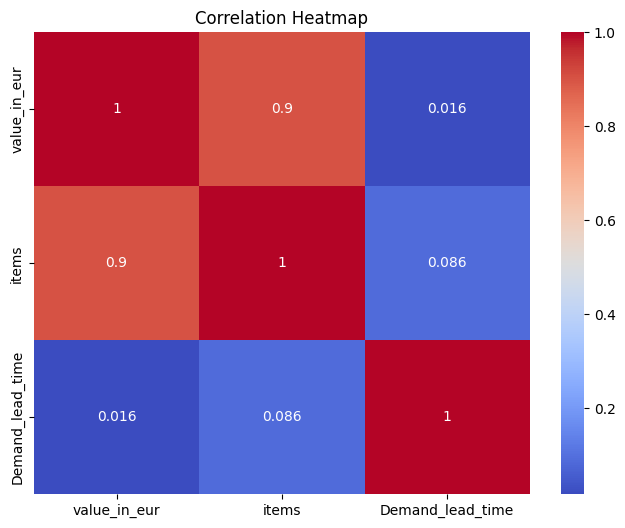

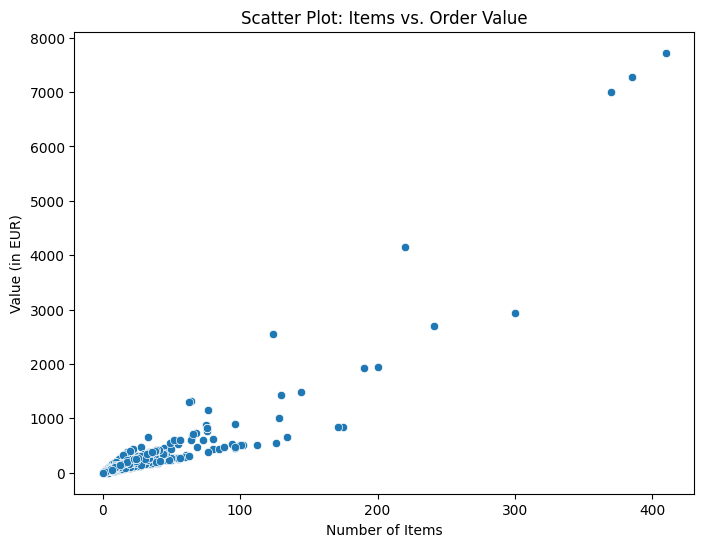

In [828]:
# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(aggregated_df[['value_in_eur', 'items', 'Demand_lead_time']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot for value_in_eur vs. items
plt.figure(figsize=(8, 6))
sns.scatterplot(data=aggregated_df, x='items', y='value_in_eur')
plt.title('Scatter Plot: Items vs. Order Value')
plt.xlabel('Number of Items')
plt.ylabel('Value (in EUR)')
plt.show()

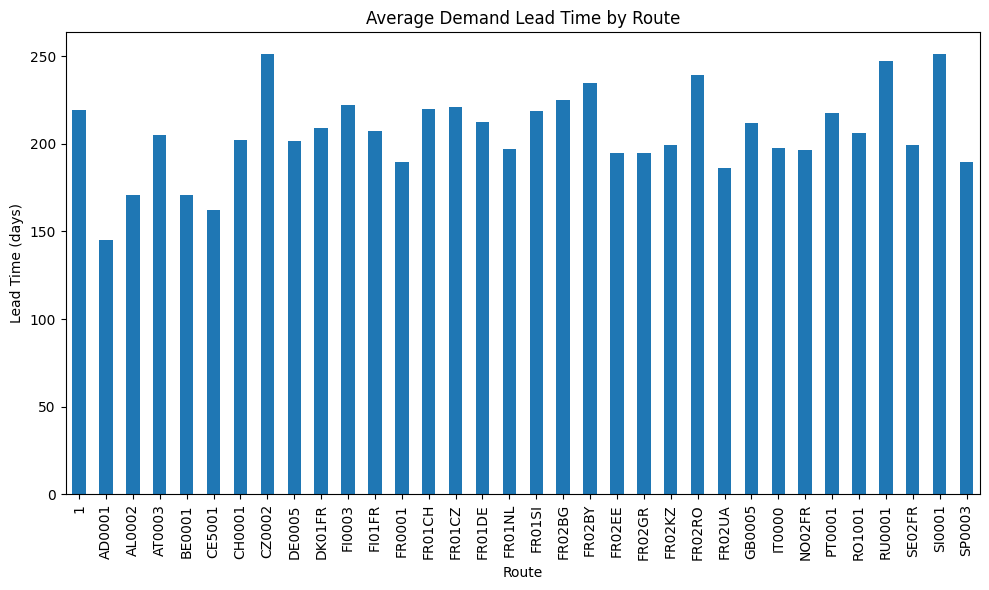

In [829]:
# Bar Plot for average demand lead time by Route
avg_lead_time_by_route = aggregated_df.groupby('Route')['Demand_lead_time'].mean()
avg_lead_time_by_route.plot(kind='bar', figsize=(10, 6))
plt.title('Average Demand Lead Time by Route')
plt.xlabel('Route')
plt.ylabel('Lead Time (days)')
plt.tight_layout()
plt.show()

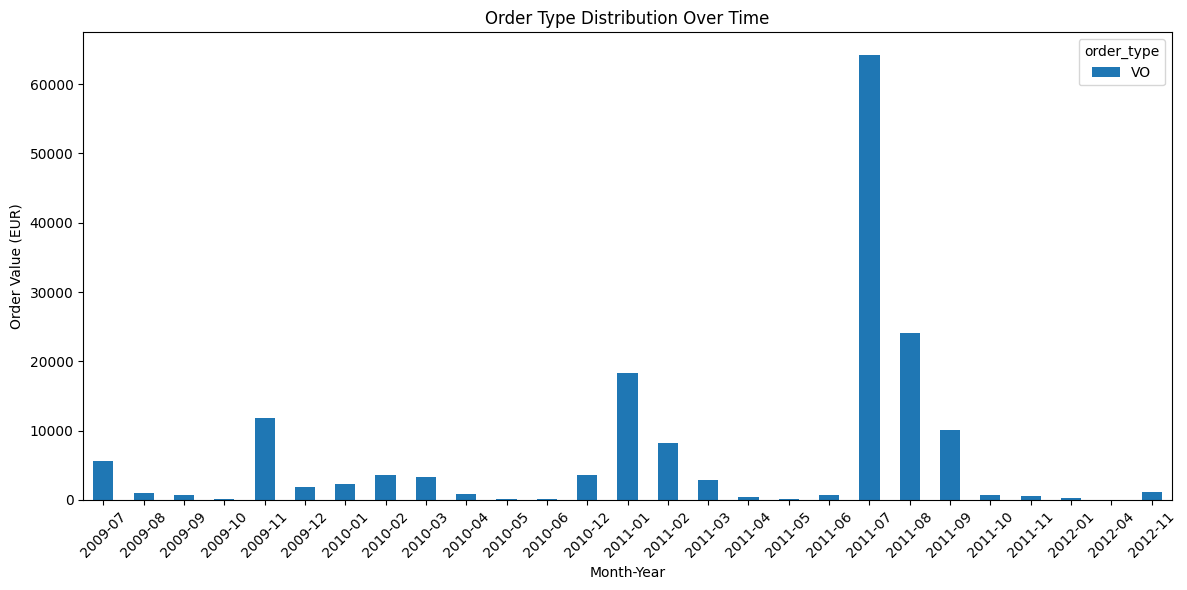

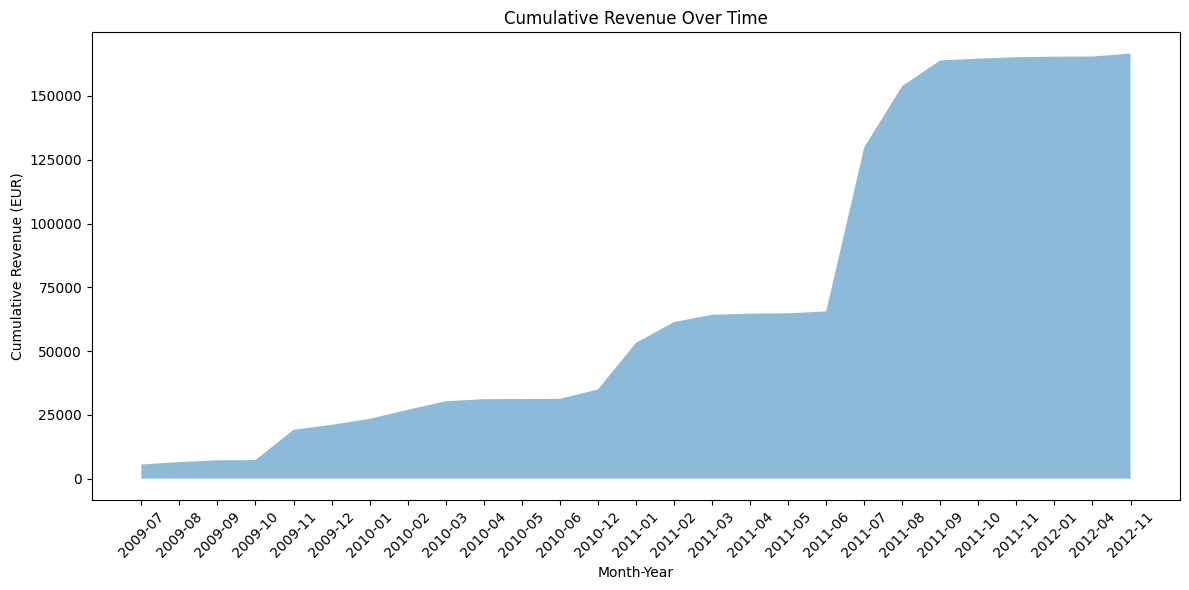

In [830]:
# Stacked bar chart for order type over time
order_type_by_time = aggregated_df.groupby(['month_year', 'order_type'])['value_in_eur'].sum().unstack()
order_type_by_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Order Type Distribution Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Order Value (EUR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Area Plot for cumulative revenue over time
cumulative_revenue = time_series.cumsum()
plt.figure(figsize=(12, 6))
plt.fill_between(cumulative_revenue.index.astype(str), cumulative_revenue.values, alpha=0.5)
plt.title('Cumulative Revenue Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Cumulative Revenue (EUR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Engineering

In [831]:
#Creating a season categorical variable to be added to our explanatory variables
df['month'] = df['order_date'].dt.month

#Mapping the months to the seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

#Creating new categorical variable 
df['season'] = df['month'].apply(get_season)

df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Demand_lead_time,month,season
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6.0,RU0001,199,7,Summer
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23.0,RU0001,252,7,Summer
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7.0,RU0001,203,7,Summer
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9.0,RU0001,202,7,Summer
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5.0,RU0001,195,7,Summer


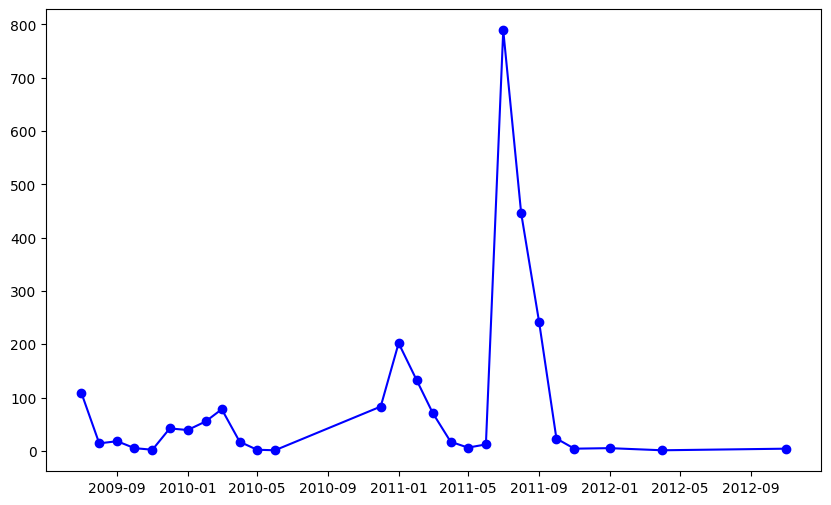

In [832]:
#Creating monthly orders - Aggregating orders by months

df['order_month'] = df['order_date'].dt.to_period('M')

monthly_orders = df.groupby('order_month').size()

# Ensure the index is in Timestamp format
monthly_orders.index = monthly_orders.index.to_timestamp()

 #Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders, label='Historical Data', color='blue', marker='o')

In [833]:
#Only 27 observations.....

monthly_orders.reset_index()

,order_month,0
0,2009-07-01,109
1,2009-08-01,14
2,2009-09-01,18
3,2009-10-01,5
4,2009-11-01,2
5,2009-12-01,42
6,2010-01-01,39
7,2010-02-01,55
8,2010-03-01,78
9,2010-04-01,17


### ARIMA Model Implementation

In [834]:
#Data Preparation - Creating a time seriries where the index is the month and the value is the number of orderd 

#From the results, the data is stationary
result = adfuller(monthly_orders)
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")


ADF Statistic: -3.060901244564924
P-value: 0.02958526370648527


In [835]:
# Train ARIMA model
model = ARIMA(monthly_orders, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -169.073
Date:                Sun, 08 Dec 2024   AIC                            344.146
Time:                        22:57:59   BIC                            347.920
Sample:                             0   HQIC                           345.233
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4701      1.161      0.405      0.686      -1.805       2.745
ma.L1         -0.9985     13.933     -0.072      0.943     -28.307      26.310
sigma2      2.386e+04   3.24e+05      0.074      0.9

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive

In [836]:
#Forecasting the next 5 months for predicted distinct orders

# Forecasting the next 5 months
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

# Create a forecast index to align with forecasted values
forecast_index = pd.date_range(start=monthly_orders.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Convert forecast to a pandas Series with proper index
forecast_series = pd.Series(data=forecast, index=forecast_index)



/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/0q/z048sjx17mz9yrftyzsvw98r0000gp/T/ipykernel_29839/4060151332.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_orders.index[-1], periods=forecast_steps + 1, freq='M')[1:]


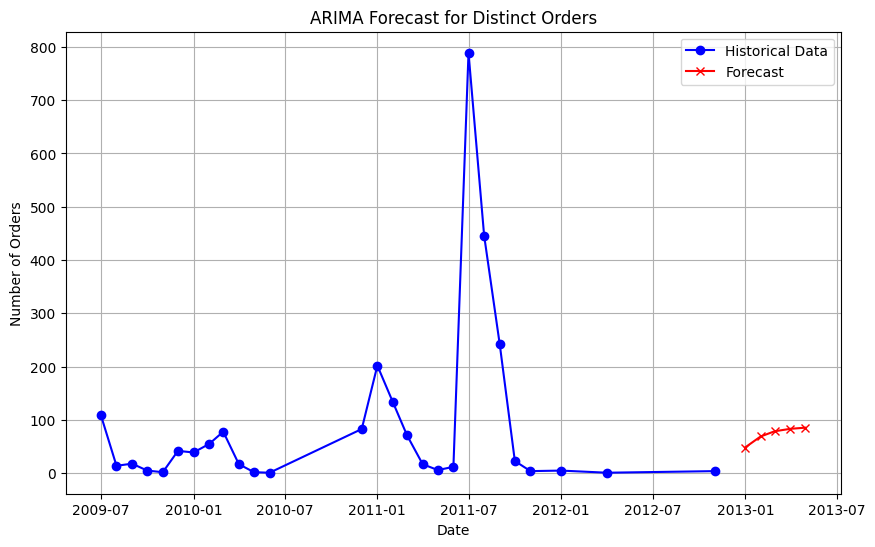

In [837]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders, label='Historical Data', color='blue', marker='o')

# Plot forecasted data
plt.plot(forecast_index, forecast, label='Forecast', color='red', marker='x')

# Add title, labels, and legend
plt.title('ARIMA Forecast for Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid()

# Show the plot
plt.show()

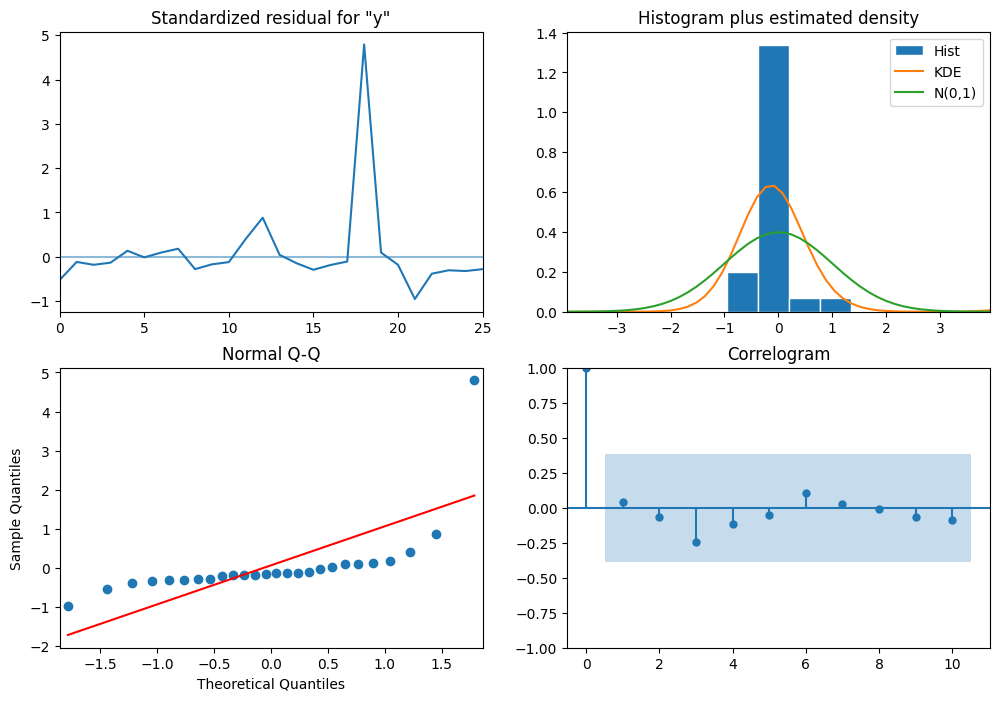

In [838]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [839]:
# Assume `monthly_orders` is a pandas Series with time as the index
# Split into train and test sets
train_data = monthly_orders[:'2010-12']
test_data = monthly_orders['2011-01':]

# Train ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))  # Example ARIMA parameters
model_fit = model.fit()

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test_data))

# Extract actual values
y_actual = test_data.values  # Actual values from the test dataset
y_forecast = forecast.values  # Forecasted values from the ARIMA model

# Calculate MAPE
def calculate_mape(y_actual, y_forecast):
    import numpy as np
    y_actual, y_forecast = np.array(y_actual), np.array(y_forecast)
    return np.mean(np.abs((y_actual - y_forecast) / y_actual)) * 100

mape = calculate_mape(y_actual, y_forecast)
print(f"MAPE: {mape:.2f}%")

MAPE: 541.63%


/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive

Extremely high MAPE score meeans the ARIMA model is performing poorly in forecasting our test data

## SARIMA Model Implementation

In [840]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2420 non-null   datetime64[ns]
 1   requested_delivery_date  2420 non-null   datetime64[ns]
 2   Customer Country Code    2420 non-null   object        
 3   Product Code             2420 non-null   object        
 4   Description              2420 non-null   object        
 5   order_type               2420 non-null   object        
 6   Customer Order Code      2420 non-null   int64         
 7   value                    2420 non-null   float64       
 8   Curr                     2420 non-null   object        
 9   items                    2074 non-null   float64       
 10  Route                    2420 non-null   object        
 11  Demand_lead_time         2420 non-null   int64         
 12  month                    2420 non-

In [841]:

# Aggregate data: Count distinct orders per month
monthly_data = df.groupby('order_month').agg({
    'Customer Order Code': 'nunique'  # Count distinct orders
}).rename(columns={'Customer Order Code': 'Distinct Orders'})

# Convert index to datetime for SARIMA compatibility
monthly_data.index = monthly_data.index.to_timestamp()
print(monthly_data.head())

             Distinct Orders
order_month                 
2009-07-01                38
2009-08-01                 9
2009-09-01                12
2009-10-01                 4
2009-11-01                 2


In [842]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

#Not enough observations


# Check stationarity and difference the data if necessary
result = adfuller(monthly_data['Distinct Orders'])
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
if result[1] > 0.05:
    monthly_data['Stationary Orders'] = monthly_data['Distinct Orders'].diff().dropna()

# Fit SARIMA model
model = SARIMAX(monthly_data['Distinct Orders'], 
                order=(1, 1, 1),  # ARIMA parameters (p, d, q)
                seasonal_order=(1, 1, 1, 12),  # SARIMA parameters (P, D, Q, s)
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()

# Print summary
print(model_fit.summary())

ADF Statistic: -3.4018288866287194, p-value: 0.010896682768471203
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                    Dis

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/state

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/0q/z048sjx17mz9yrftyzsvw98r0000gp/T/ipykernel_29839/1660352479.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


27    -35.028130
28    -70.682431
29    -85.995501
30    -98.001633
31    119.263090
32     51.760713
33    -61.548701
34   -154.707164
35   -182.758878
36   -203.750343
37   -223.730482
38   -244.750764
Name: predicted_mean, dtype: float64


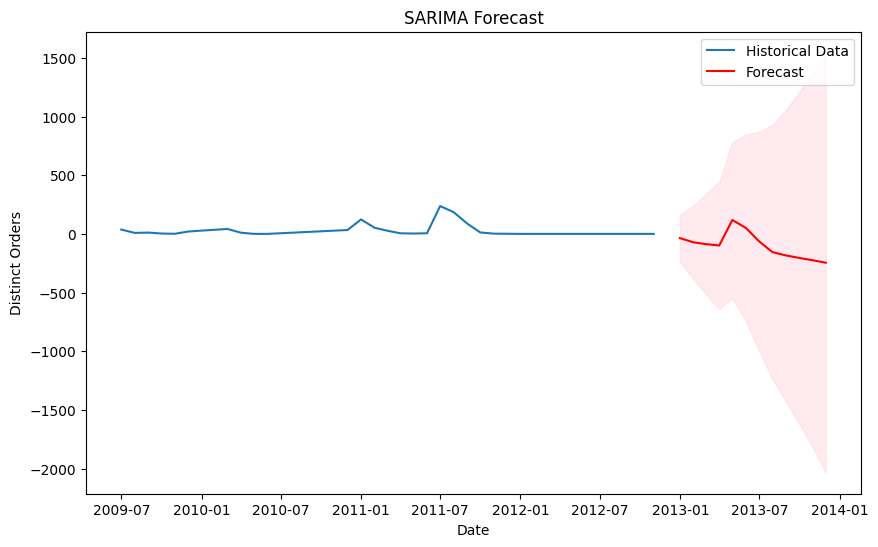

In [843]:
# Forecast next 12 months
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(
    start=monthly_data.index[-1], periods=forecast_steps + 1, freq='M'
)[1:]

# Forecast values
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Print forecast
print(forecast_mean)

# Plot forecast with confidence intervals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['Distinct Orders'], label='Historical Data')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Distinct Orders")
plt.show()

In [844]:

# Actual values (from the test set)
y_actual = monthly_data['Distinct Orders'][-12:]  # Replace -12 with the appropriate range of test data

# Forecasted values (from SARIMA model)
y_forecast = forecast.predicted_mean  # Replace with your forecasted values for the same test period

# Ensure both are aligned and converted to numpy arrays
y_actual = np.array(y_actual)
y_forecast = np.array(y_forecast)

# Compute MAPE
def calculate_mape(y_actual, y_forecast):
    # Avoid division by zero
    non_zero_mask = y_actual != 0
    return np.mean(np.abs((y_actual[non_zero_mask] - y_forecast[non_zero_mask]) / y_actual[non_zero_mask])) * 100

mape = calculate_mape(y_actual, y_forecast)
print(f"MAPE: {mape:.2f}%")

MAPE: 6731.54%


This is a horrible score.... SARIMA is not compatible with this dataset

In [845]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Demand_lead_time,month,season,order_month
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6.0,RU0001,199,7,Summer,2009-07
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23.0,RU0001,252,7,Summer,2009-07
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7.0,RU0001,203,7,Summer,2009-07
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9.0,RU0001,202,7,Summer,2009-07
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5.0,RU0001,195,7,Summer,2009-07


# Multi-Classification Model

Going to use Random Forest and XG Boost

In [846]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define categorical and numerical columns
categorical_features = ['Customer Country Code', 'Route', 'season']
numerical_features = ['items', 'value']
target = 'Product Code'

# Split dataset into features (X) and target (y)
X = df[categorical_features + numerical_features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ]
)

# Random Forest pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.14
Random Forest Classification Report:
              precision    recall  f1-score   support

   L10705000       0.50      1.00      0.67         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         8
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10705700       0.00      0.00      0.00         0
   L10850600       0.14      0.06      0.09        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.14      0.17      0.15        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.33      0.38      0.35         8
   L10852900       0.00      0.00      0.00         6
   L10853100       0.00      0.00      0.00         0
   L12134400       0.25      0.19      0.22        26
   L12134500   

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [847]:
#Hyper Parameter Tuning for Random Forest

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],       # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],     # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5, 10],     # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]        # Minimum samples required at a leaf node
}

# Initialize GridSearchCV with the rf_model pipeline
grid_search = GridSearchCV(estimator=rf_model,      # Use the existing pipeline
                           param_grid=param_grid, 
                           scoring='accuracy',      # Metric for evaluation
                           cv=5,                    # 5-fold cross-validation
                           verbose=1)               # Show progress

# Perform the grid search
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}


In [848]:
#rf_model = Pipeline(steps=[('preprocessor', preprocessor), ('rf', RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 50))])

In [849]:
# Random Forest with best parameters

rf_model = Pipeline(steps=[('preprocessor', preprocessor), ('rf', RandomForestClassifier(max_depth= 10, min_samples_leaf= 4, min_samples_split=10, n_estimators= 50))])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("Random Forest Classification Report: ")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.18
Random Forest Classification Report: 
              precision    recall  f1-score   support

   L10705000       0.00      0.00      0.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         8
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.27      0.38      0.32        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.31      0.42      0.36        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.33      0.25      0.29         8
   L10852900       0.00      0.00      0.00         6
   L12134400       0.32      0.27      0.29        26
   L12134500       0.00      0.00      0.00        13
   L12134600       0.00      0.00      0.00        10
   L12134700  

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

### Quantity Demanded XGB Regression Model

In [850]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Demand_lead_time,month,season,order_month
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6.0,RU0001,199,7,Summer,2009-07
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23.0,RU0001,252,7,Summer,2009-07
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7.0,RU0001,203,7,Summer,2009-07
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9.0,RU0001,202,7,Summer,2009-07
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5.0,RU0001,195,7,Summer,2009-07


In [851]:
# Define categorical and numerical columns
categorical_features = ['Customer Country Code', 'Product Code', 'Route', 'season']
numerical_features = ['value', 'Demand_lead_time']

# Target variable
target = 'items'

# Split dataset into features (X) and target (y)
X = df[categorical_features + numerical_features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ]
)


In [852]:
#Converting all Nulls in item to 0s so the model can work...

df['items'] = df['items'].fillna(0)

In [853]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Check and clean the target variable
y = y.replace([np.inf, -np.inf], np.nan).dropna()
X = X.loc[y.index]  # Ensure alignment

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ]
)

# XGBoost model
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', 
                               n_estimators=100, 
                               max_depth=6, 
                               learning_rate=0.1, 
                               random_state=42))
])

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 7.93


In [854]:
# Define parameter grid
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Best Score: 96.15070256306832


In [855]:
#Run XGB Regressor with best params

# Ensure no missing values
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

# Convert categorical columns to numeric using preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)

# Ensure y_train is numeric
if y_train.dtypes == 'object':
    from sklearn.preprocessing import LabelEncoder
    y_train = LabelEncoder().fit_transform(y_train)

# Run the XGBRegressor with best parameters
best_xgb_model = XGBRegressor(
    n_estimators=best_params['regressor__n_estimators'],
    max_depth=best_params['regressor__max_depth'],
    learning_rate=best_params['regressor__learning_rate'],
    objective='reg:squarederror',
    random_state=42
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Predict on the test set (make sure to preprocess X_test as well)
X_test = preprocessor.transform(X_test)
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error with Best Parameters: {mse:.2f}")

Mean Squared Error with Best Parameters: 5.25


THIS MODEL POPPED OFF WITH THE ACCURACY

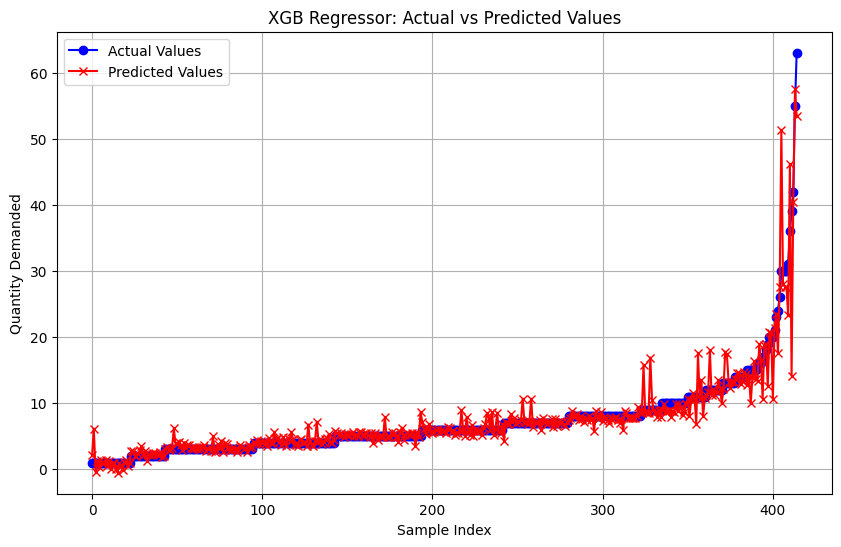

In [856]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the actual and predicted values for better visualization
sorted_indices = np.argsort(y_test)
sorted_y_test = y_test.iloc[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(sorted_y_test.values, label="Actual Values", marker="o", color="blue")
plt.plot(sorted_y_pred, label="Predicted Values", marker="x", color="red")

# Add title, labels, and legend
plt.title("XGB Regressor: Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Quantity Demanded")
plt.legend()
plt.grid()

# Show the plot
plt.show()

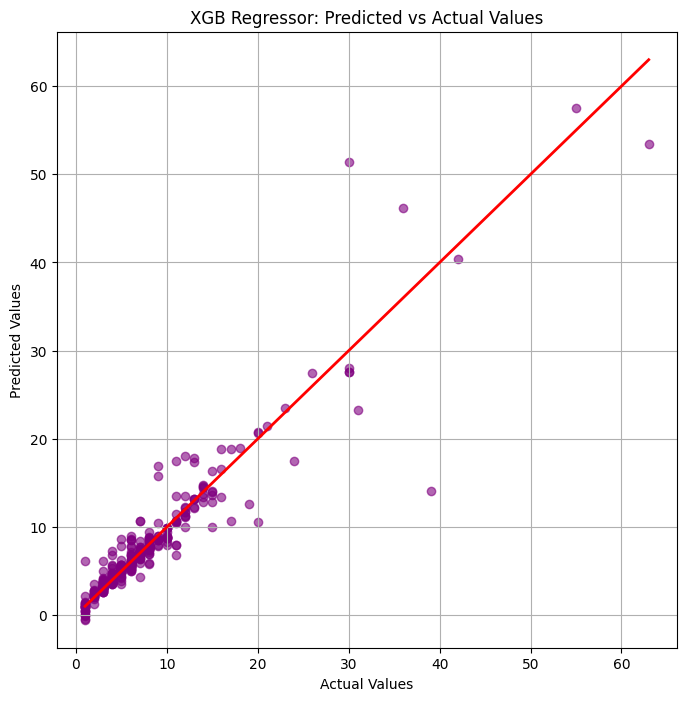

In [857]:
# Scatter plot for Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2)  # 45-degree line

# Add title and labels
plt.title("XGB Regressor: Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()

# Show the plot
plt.show()

# Demand Lead Time for Orders

In [858]:
#Demand lead time in quarters

#I chose the quarter names arbitrarily since it wasn't clarified in the rubric
lead_time_quantiles = df['Demand_lead_time'].quantile([0.25, 0.5, 0.75])
print("Lead Time Quantiles:\n", lead_time_quantiles)

def categorize_lead_time(days):
    if days <= lead_time_quantiles[0.25]:
        return 'Short'
    elif days <= lead_time_quantiles[0.75]:
        return 'Medium'
    else:
        return 'Long'

df['Lead_Time_Category'] = df['Demand_lead_time'].apply(categorize_lead_time)

# Optional: Analyze lead time categories
print(df['Lead_Time_Category'].value_counts())

Lead Time Quantiles:
 0.25    196.0
0.50    217.0
0.75    251.0
Name: Demand_lead_time, dtype: float64
Lead_Time_Category
Medium    1215
Short      621
Long       584
Name: count, dtype: int64


In [859]:
aggregated_df.head()


,Customer Order Code,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,value,Curr,items,Route,Demand_lead_time,value_in_eur,month_year
0,3200435283,2009-07-08,2010-02-04,RU,L10705400,Parka Outdoor Lifestyle STD,VO,13148.00,RUB,32.0,RU0001,211.0,157.78,2009-07
1,3200435289,2009-07-08,2010-01-28,RU,"L10705100, L10705200, L10705400, L10705600, L1...","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,12810.75,RUB,29.0,RU0001,204.0,153.73,2009-07
2,3200435553,2009-07-13,2010-01-28,RU,"L10705000, L10705100, L10705400","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,15190.50,RUB,39.0,RU0001,199.0,182.29,2009-07
3,3200435605,2009-07-14,2010-01-28,RU,L10705300,Parka Outdoor Lifestyle STD,VO,3847.50,RUB,9.0,RU0001,198.0,46.17,2009-07
4,3200435675,2009-07-15,2010-02-01,RU,"L10705100, L10705300, L10705400, L10705600","Parka Outdoor Lifestyle STD, Parka Outdoor Lif...",VO,13537.50,RUB,30.0,RU0001,201.0,162.45,2009-07


### Monte Carlo

In [860]:
# Monte Carlo Sim for total Demand

n_simulations = 1000
simulated_demands = []
for _ in range(n_simulations):
    sampled_lead_times = aggregated_df['Demand_lead_time'].sample(len(aggregated_df), replace=True)
    sampled_quantities = aggregated_df['items'].sample(len(aggregated_df), replace=True)
    total_demand = (sampled_lead_times * sampled_quantities).sum()
    simulated_demands.append(total_demand)

# Analyze and visualize simulation results
simulated_demands = np.array(simulated_demands)
print("Simulated Total Demand (Mean):", simulated_demands.mean())
print("Simulated Total Demand (Std Dev):", simulated_demands.std())


Simulated Total Demand (Mean): 3842864.913821428
Simulated Total Demand (Std Dev): 432629.90328483295


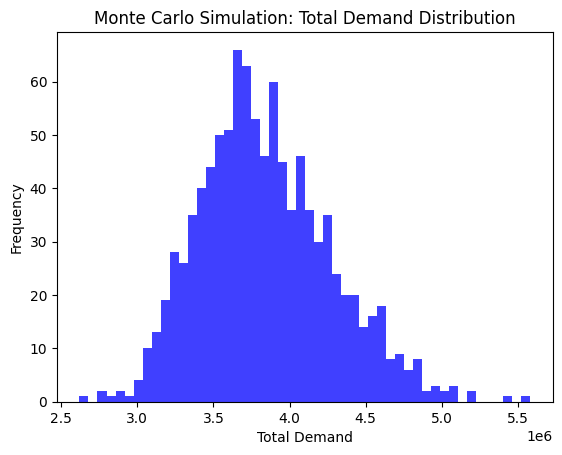

95% Confidence Interval: [3108806.30047619 4767912.53732143]


In [861]:
# Place after Monte Carlo simulation is complete
plt.hist(simulated_demands, bins=50, alpha=0.75, color='blue')
plt.title('Monte Carlo Simulation: Total Demand Distribution')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.show()

# Add confidence interval calculation
conf_interval = np.percentile(simulated_demands, [2.5, 97.5])
print("95% Confidence Interval:", conf_interval)


In [862]:
# Comparision of simulated advance demand to actual advance demand in test data
actual_advance_demand = aggregated_df['Demand_lead_time'].sum()  # Example: Adjust as per actual dataset
simulated_mean_demand = simulated_demands.mean()

print(f"Actual Advance Demand: {actual_advance_demand}")
print(f"Simulated Mean Advance Demand: {simulated_mean_demand}")

# Calculate percentage difference
percentage_difference = ((simulated_mean_demand - actual_advance_demand) / actual_advance_demand) * 100
print(f"Percentage Difference: {percentage_difference:.2f}%")



Actual Advance Demand: 213219.74563492063
Simulated Mean Advance Demand: 3842864.913821428
Percentage Difference: 1702.30%


Lognormal Parameters: Shape=4.463244880487657, Location=-2.1868130009414572e-09, Scale=0.9769285071267921


/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:6556: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


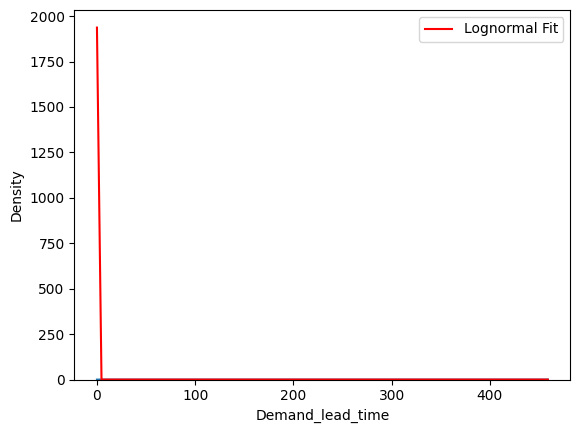

In [863]:
from scipy.stats import lognorm

# Fit lognormal distribution to demand lead time
shape, loc, scale = lognorm.fit(df['Demand_lead_time'])
print(f"Lognormal Parameters: Shape={shape}, Location={loc}, Scale={scale}")

# Plot distribution
sns.histplot(df['Demand_lead_time'], kde=True, stat='density')
x = np.linspace(df['Demand_lead_time'].min(), df['Demand_lead_time'].max(), 100)
plt.plot(x, lognorm.pdf(x, shape, loc, scale), label='Lognormal Fit', color='red')
plt.legend()
plt.show()


In [864]:
#As we can see from above this was completely pointless and transforming it doesn't do anything

# Final Edits

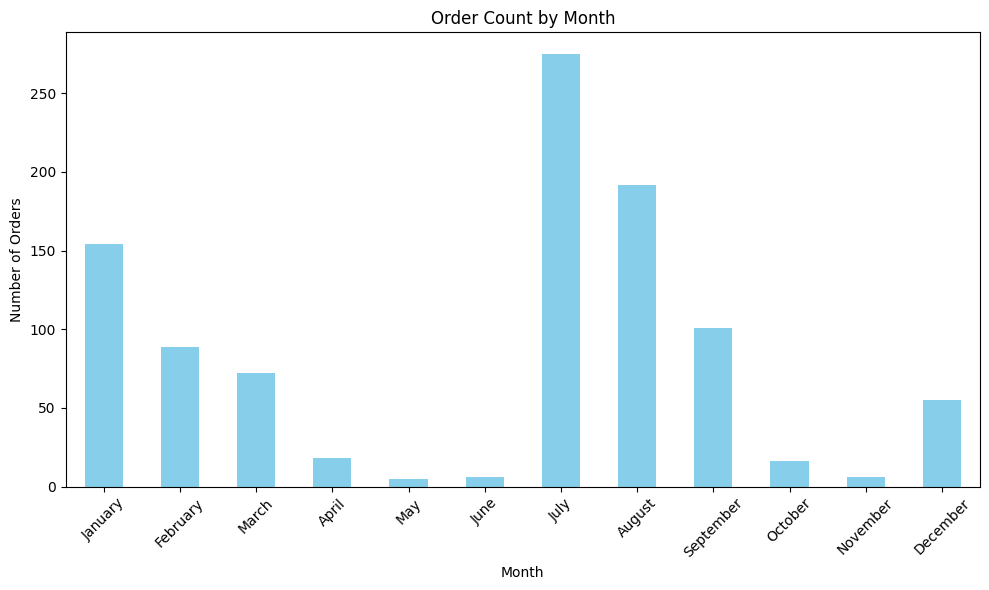

In [865]:
# distinct orders by month
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'order_date' is in datetime format
aggregated_df['order_date'] = pd.to_datetime(aggregated_df['order_date'], errors='coerce')

# Extract the month (as the name of the month)
aggregated_df['month'] = aggregated_df['order_date'].dt.month_name()

# Count orders by month
orders_by_month = aggregated_df['month'].value_counts().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 
     'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot the order count by month
plt.figure(figsize=(10, 6))
orders_by_month.plot(kind='bar', color='skyblue')
plt.title('Order Count by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# HACKATHON STRATEGY

1. Cleaning and EDA

2. Group total transactions into months to gather the distict orders (uses aggregated df) - Monthly Info

3. Specifically Prediction # of distinct orders per month using a time-series forecasting model (ARIMA / SARIMA)

3. Develop Multi-Class Model to identify which products the customer will order based on historical patterns and SEASONALITY (utilitze OHE) 
    - Using RF for classification

4. Develop a predicting model for Quantity Demanded (items) for each product using XGB Regressor or quantiles (or other methods)

5. Obtain Demand Lead Time using Monte Carlo Simulation, consolidating it into total demand

6. Consolidate the models into demand forecasting, (Combining all the models into a final predictive forecasting model) - Used to quantify performance

7. Scenario Analysis to evaluate how reducing demand time can impact the demand predictions 